In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Dependencies

In [2]:
!pip install numpy pandas librosa tqdm resampy joblib audiomentations tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0


## Import the required Libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift
from collections import Counter
import collections
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras import layers, models

# DATA Loading

In [4]:
#Dictionary for emotion Mapping
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def load_data(speech_dir, song_dir):
    data = []

    for base_dir, source in [(speech_dir, 'speech'), (song_dir, 'song')]:
        for actor_folder in os.listdir(base_dir):
            actor_path = os.path.join(base_dir, actor_folder)
            if not os.path.isdir(actor_path):
                continue

            for filename in os.listdir(actor_path):
                if filename.endswith(".wav"):
                    parts = filename.split("-")
                    emotion_code = parts[2]
                    emotion_label = emotion_map.get(emotion_code)
                    if emotion_label:
                        full_path = os.path.join(actor_path, filename)
                        data.append([full_path, emotion_label, source])

    df = pd.DataFrame(data, columns=["path", "emotion", "source"])
    return df

speech_dir = "/content/drive/MyDrive/projects/MaRS_open_project/dataset/raw_data/Audio_Speech_Actors_01-24"
song_dir = "/content/drive/MyDrive/projects/MaRS_open_project/dataset/raw_data/Audio_Song_Actors_01-24"

df = load_data(speech_dir, song_dir)
print(df.head())
print("Total samples:", len(df))
print("Class distribution:\n", df['emotion'].value_counts())

                                                path  emotion  source
0  /content/drive/MyDrive/projects/MaRS_open_proj...     calm  speech
1  /content/drive/MyDrive/projects/MaRS_open_proj...    happy  speech
2  /content/drive/MyDrive/projects/MaRS_open_proj...    happy  speech
3  /content/drive/MyDrive/projects/MaRS_open_proj...    happy  speech
4  /content/drive/MyDrive/projects/MaRS_open_proj...  neutral  speech
Total samples: 2452
Class distribution:
 emotion
calm         376
happy        376
sad          376
fearful      376
angry        376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64


**NOTE** : We have less examples for disgust, surprised and neutral,   
So we'll be using class weights to address this issue.

## FUNCTION for feature extraction

In [5]:
def pad_or_trunc(x, max_len=174):
    if x.shape[1] < max_len:
        return np.pad(x, ((0, 0), (0, max_len - x.shape[1])), mode='constant')
    else:
        return x[:, :max_len]

def extract_features(path, max_pad_len=174):
    try:
        y, sr = librosa.load(path, sr=22050)
        stft = np.abs(librosa.stft(y))

        #Extracts the features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)

        #Pad_or_trunc for safety
        mfcc = pad_or_trunc(mfcc, max_pad_len)
        chroma = pad_or_trunc(chroma, max_pad_len)
        mel = pad_or_trunc(mel, max_pad_len)
        contrast = pad_or_trunc(contrast, max_pad_len)

        #Stacking the features
        return np.vstack([mfcc, chroma, mel, contrast])
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


## Feature Extraction

In [ ]:
# features = []
# labels = []

# for i, row in df.iterrows():
#     feat = extract_features(row['path'])
#     if feat is not None:
#         features.append(feat)
#         labels.append(row['emotion'])

# X = np.array(features)  # shape: (samples, 187, 174)
# y = np.array(labels)

# print("X shape:", X.shape)
# print("y shape:", y.shape)


X shape: (2452, 187, 174)
y shape: (2452,)


**NOTE:** Too slow process took 11 minutes   
Tried doing this using joblib which uses all cpu cores at the same time which speeds up the process relatively.

In [ ]:
# Make tqdm work nicely with joblib
tqdm.pandas()

# Function to wrap for joblib
def process_row(row):
    feat = extract_features(row.path)
    return (feat, row.emotion) if feat is not None else None

results = Parallel(n_jobs=-1)(
    delayed(process_row)(row) for row in tqdm(df.itertuples(index=False), total=len(df))
)
results = [r for r in results if r is not None]
features, labels = zip(*results)
X = np.array(features)
y = np.array(labels)

print("X shape:", X.shape)
print("y shape:", y.shape)

100%|██████████| 2452/2452 [14:15<00:00,  2.87it/s]


X shape: (2452, 187, 174)
y shape: (2452,)


### Save the Features
Saving the file so that it doesn't always take too much time to load

In [ ]:
joblib.dump((X, y), "/content/drive/MyDrive/projects/MaRS_open_project/cached_features.pkl")

Loading the saved features

In [6]:
X, y = joblib.load("/content/drive/MyDrive/projects/MaRS_open_project/cached_features.pkl")
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2452, 187, 174)
y shape: (2452,)


### Label Encoder

In [7]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
joblib.dump(le, "/content/drive/MyDrive/projects/MaRS_open_project/label_encoder.pkl")
# X, y = joblib.load("/content/drive/MyDrive/projects/MaRS_open_project/label_encoder.pkl")

['/content/drive/MyDrive/projects/MaRS_open_project/label_encoder.pkl']

In [8]:
print("Before flattening:", X.shape)

Before flattening: (2452, 187, 174)


# Train Test Split

In [9]:
X_temp = X.reshape(-1, X.shape[2])
scaler = StandardScaler()
X_temp = scaler.fit_transform(X_temp)
X_scaled = X_temp.reshape(X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X_flat, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
# )

# print("Train shape:", X_train.shape)
# print("Test shape:", X_test.shape)

Train shape: (1961, 32538)
Test shape: (491, 32538)


In [ ]:
# scaler = StandardScaler()

# # Fit on training data only
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# #save the scaler to load later
# joblib.dump(scaler, "/content/drive/MyDrive/projects/MaRS_open_project/scaler.pkl")

# print("X_train_scaled shape:", X_train_scaled.shape)
# print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (1961, 32538)
X_test_scaled shape: (491, 32538)


In [ ]:
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weights_dict = dict(enumerate(class_weights))

# print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.8143687707641196), 1: np.float64(0.8143687707641196), 2: np.float64(1.602124183006536), 3: np.float64(0.8143687707641196), 4: np.float64(0.8143687707641196), 5: np.float64(1.6341666666666668), 6: np.float64(0.8143687707641196), 7: np.float64(1.602124183006536)}


In [ ]:
# model = models.Sequential([
#     layers.Input(shape=(X_train_scaled.shape[1],)),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(len(np.unique(y_train)), activation='softmax')
# ])

# model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Compute class weights
# from sklearn.utils.class_weight import compute_class_weight

# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# # Train the model
# history = model.fit(
#     X_train_scaled, y_train,
#     epochs=30,
#     validation_split=0.1,
#     batch_size=32,
#     class_weight=class_weight_dict
# )

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.3410 - loss: 5.4179 - val_accuracy: 0.5025 - val_loss: 2.0481
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.6479 - loss: 1.8398 - val_accuracy: 0.5685 - val_loss: 1.7880
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.7602 - loss: 0.8630 - val_accuracy: 0.5533 - val_loss: 1.9044
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.8196 - loss: 0.7417 - val_accuracy: 0.6091 - val_loss: 1.7544
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.8251 - loss: 0.7074 - val_accuracy: 0.5838 - val_loss: 1.7903
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.8809 - loss: 0.4421 - val_accuracy: 0.6396 - val_loss: 1.9203
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.9088 - loss: 0.3442 - val_accuracy: 0.6396 - val_loss: 1.6702
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9157 - loss: 0.5025 - val_accuracy: 0.6

## MODEL  
CNN + BiDirectional LSTM used

In [10]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),  # (174, 187)

    # 1D Convolution
    layers.Conv1D(64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    # BiLSTM
    layers.Bidirectional(layers.LSTM(128, return_sequences=False)),
    layers.Dropout(0.3),

    # Output
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 183, 64)        │        55,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 91, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 91, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,344 (1.03 MB)

 Trainable params: 270,344 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

### Class weights and model fitting

In [14]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

model.fit(
    X_train, y_train_enc,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7169 - loss: 0.7582 - val_accuracy: 0.6396 - val_loss: 1.1180
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7645 - loss: 0.6771 - val_accuracy: 0.6751 - val_loss: 1.0572
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7774 - loss: 0.6011 - val_accuracy: 0.6396 - val_loss: 1.0721
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7831 - loss: 0.5859 - val_accuracy: 0.6650 - val_loss: 1.1264
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7562 - loss: 0.6869 - val_accuracy: 0.6751 - val_loss: 1.1162
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8249 - loss: 0.5137 - val_accuracy: 0.6650 - val_loss: 1.0363
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8188 - loss: 0.4890 - val_accuracy: 0.6497 - val_loss: 1.0106
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8422 - loss: 0.4258 - val_accuracy: 0.6548 - v

# Model Evaluation

In [15]:
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test_enc, y_pred_labels, target_names=le.classes_))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

       angry       0.73      0.77      0.75        75
        calm       0.80      0.80      0.80        75
     disgust       0.66      0.49      0.56        39
     fearful       0.67      0.59      0.62        75
       happy       0.68      0.71      0.69        75
     neutral       0.62      0.92      0.74        38
         sad       0.62      0.63      0.62        75
   surprised       0.81      0.67      0.73        39

    accuracy                           0.70       491
   macro avg       0.70      0.70      0.69       491
weighted avg       0.70      0.70      0.69       491



In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [21]:
cm = confusion_matrix(y_test_enc, y_pred_labels)


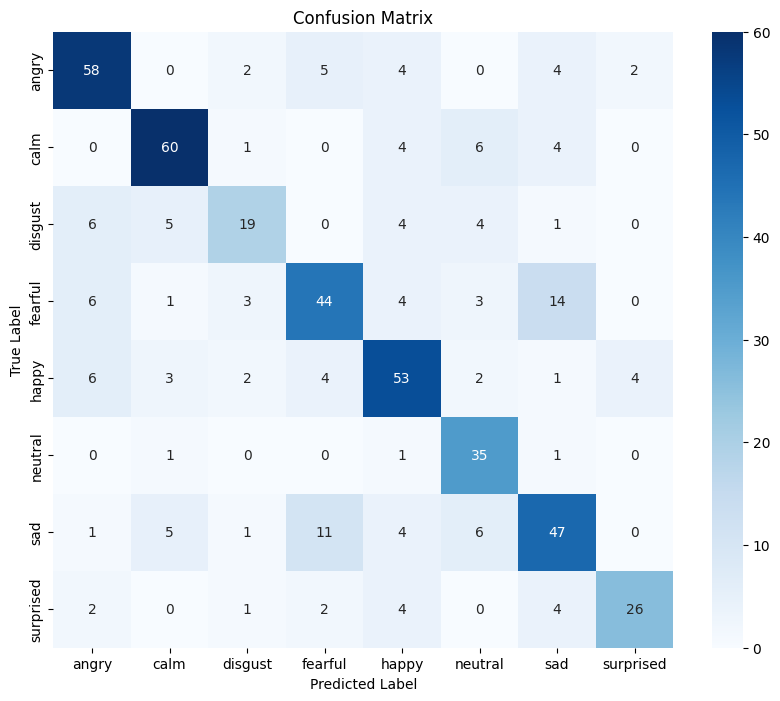

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Save The Model

In [18]:
model.save("/content/drive/MyDrive/projects/MaRS_open_project/models/emotion_model.h5")

In [19]:
model.save('/content/drive/MyDrive/projects/MaRS_open_project/models/emotion_model.keras')